## First Layer Visualization

/home/ash/miniconda3/envs/lucid-env/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/ash/miniconda3/envs/lucid-env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: 94
Predicted class name: hummingbird


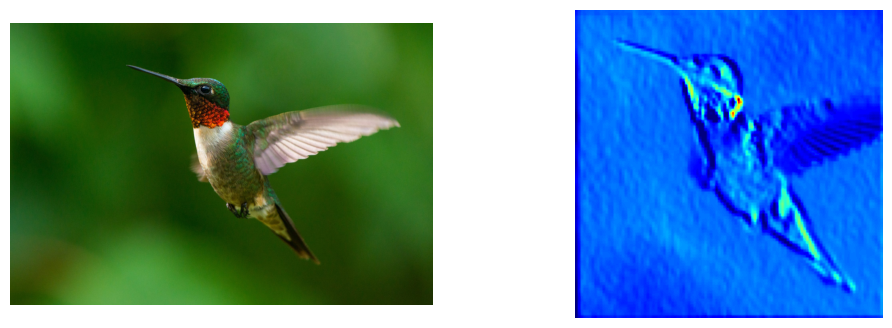

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms 

import matplotlib.pyplot as plt 
from PIL import Image

from imgnet_lbls import imagenet_labels

# Load an image
img = Image.open('/home/ash/Desktop/hbird.jpg')

# Load model  
model = models.googlenet(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Transform image   
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
img_t = transform(img)

first_conv_layer = None  
for name, layer in model.named_modules():
    if 'conv' in name:
        first_conv_layer = layer
        break  # Stop after finding the first convolutional layer
        
# Define hook to get activations
activations = []  
def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

# Register hook
first_conv_layer.register_forward_hook(get_activation('conv_1'))   

# Run model  
output = model(img_t.unsqueeze(0))       

# Get activations
activations = activations[0]  

# Get prediction
_, predicted = torch.max(output, 1)
print('Predicted class:', predicted.item())
class_name = imagenet_labels[predicted.item()]
print(f'Predicted class name: {class_name}')

# Plot 
plt.figure(figsize=(12,4))

# Subplot for the original image
plt.subplot(1,2,1)   
plt.imshow(img)   
plt.axis('off')

# Subplot for the activations
plt.subplot(1,2,2)
plt.imshow(activations[0, 25, :, :].squeeze(), cmap='jet')  
plt.axis('off')

plt.show()

## Last Layer Visualization

/home/ash/miniconda3/envs/lucid-env/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/ash/miniconda3/envs/lucid-env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: 94
Predicted class name: hummingbird


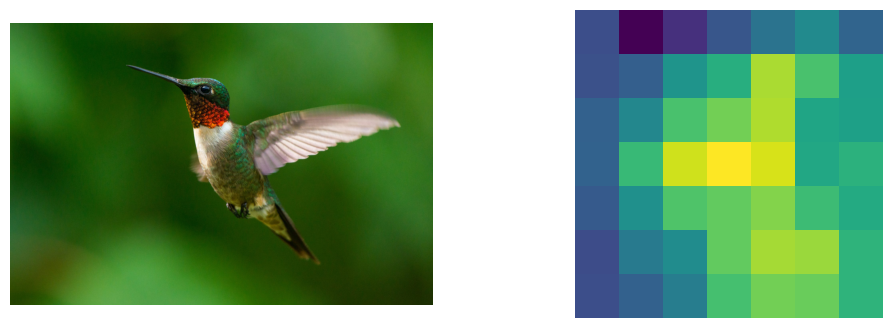

In [2]:
# Load an image
img = Image.open('/home/ash/Desktop/hbird.jpg')

# Load model  
model = models.googlenet(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Transform image   
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
img_t = transform(img)

# Get last convolutional layer  
last_conv_layer = None  
for name, layer in model.named_modules():
    if 'conv' in name:
        last_conv_layer = layer
        
# Define hook to get activations to allow us to register a 
#function to be executed at a specific point during the forward or backward pass 
activations = []  
def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

# Register hook
last_conv_layer.register_forward_hook(get_activation('conv_4'))   

# Run model  
output = model(img_t.unsqueeze(0))       

# Get activations
activations = activations[0]  

# Get prediction
_, predicted = torch.max(output, 1)
print('Predicted class:', predicted.item())
class_name = imagenet_labels[predicted.item()]
print(f'Predicted class name: {class_name}')

# Plot 
plt.figure(figsize=(12,4))

# Subplot for the original image
plt.subplot(1,2,1)   
plt.imshow(img)   
plt.axis('off')

# Subplot for the activations
plt.subplot(1,2,2)
plt.imshow(activations[0, 3, :, :].squeeze(), cmap='viridis')  
plt.axis('off')

plt.show()

## Activation Maximization

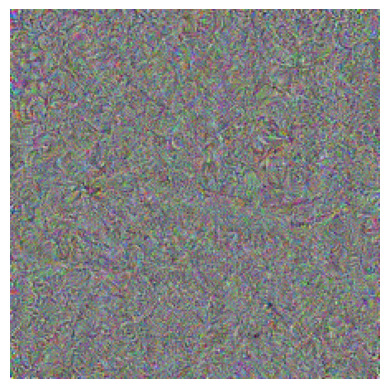

In [3]:
#Activation maximization is a technique used to generate images that maximize 
#the activation of specific neurons or filters in a neural network.
#In the case of curve detectors, the goal is to create an input image that 
#elicits strong activations in the neurons responsible for detecting curves. 
#By iteratively updating the input image to maximize the activation of these neurons, 
#the resulting image tends to exhibit pronounced curves or curve-like patterns.

from torch.autograd import Variable


# Load model  
model = models.googlenet(pretrained=True)
model.eval()

# Choose a neuron
layer_name = 'inception5b.branch4.1.conv'  # Name of the layer containing the neuron
neuron_index = 0  # Index of the neuron in the layer

# Get the chosen layer
layer = dict(model.named_modules())[layer_name]

# Define a hook to get the activation of the chosen neuron
activation = None
def hook(module, input, output):
    global activation
    activation = output[0, neuron_index].mean()


# Register the hook
handle = layer.register_forward_hook(hook)

# Generate a random input image
input_image = Variable(torch.randn(1, 3, 224, 224), requires_grad=True)

# Define an optimizer
optimizer = torch.optim.Adam([input_image], lr=0.1)

# Perform Activation Maximization
for i in range(100):
    optimizer.zero_grad()
    model(input_image)
    loss = -activation
    loss.backward()
    optimizer.step()

# Remove the hook
handle.remove()

# The resulting input_image should now be an image that maximally activates the chosen neuron

# Convert the tensor to a numpy array
image = input_image.detach().numpy()

# Move the color channel to the last dimension
image = np.transpose(image, (0, 2, 3, 1))

# Normalize the image to the range [0, 1]
image -= image.min()
image /= image.max()

# Plot the image
plt.imshow(image[0], cmap='plasma')
plt.axis('off')
plt.show()


## Activation Maximization using Lucent (Lucid for Pytorch) Library 
 Check file activation_maximization_using_lucent.png for output 


In [8]:
from lucent.optvis import render
from lucent.modelzoo import inceptionv1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
model.to(device).eval()
render.render_vis(model, "mixed4d:25")


100%|█████████████████████████████████████████| 512/512 [00:50<00:00, 10.07it/s]


[array([[[[0.60253996, 0.66153926, 0.49541906],
          [0.22097056, 0.17226815, 0.1078281 ],
          [0.5164046 , 0.34893882, 0.28229058],
          ...,
          [0.5152631 , 0.62143296, 0.46791345],
          [0.34418252, 0.25314775, 0.24111941],
          [0.3209127 , 0.20313713, 0.18759318]],
 
         [[0.37019596, 0.36709   , 0.51630706],
          [0.6250188 , 0.35574222, 0.22657926],
          [0.95495105, 0.9523373 , 0.71968347],
          ...,
          [0.90231454, 0.9013686 , 0.48121879],
          [0.94145185, 0.9648461 , 0.86185104],
          [0.31982255, 0.34832415, 0.32664305]],
 
         [[0.42262796, 0.35934833, 0.19984227],
          [0.90609545, 0.82335955, 0.5529032 ],
          [0.7817554 , 0.7788091 , 0.28398252],
          ...,
          [0.79345226, 0.6695065 , 0.2041866 ],
          [0.890694  , 0.87482446, 0.33262318],
          [0.6534343 , 0.75468624, 0.5831196 ]],
 
         ...,
 
         [[0.72331506, 0.76831806, 0.76915157],
          [0.21360